# **Changing to transfer learning with resnet**

From the previous model, we have swapped out the model for resnet that has been pretrained and tweaking it to use our data and classes.

Validation Loss: 1.417
Validation Accuracy: 81.99%
FLOPS: 2.15G


In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2023
### Student Name: Nathaniel Chang, Tommy Hick
### Student ID: a1821595, a1825267
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC: 85.00% FLOPs: 2.15G
##################################################################################################################################

In [2]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Mounting G-Drive to get your dataset.
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = './animal/dataset/dataset/'
classes = os.listdir(data_dir)

In [4]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Randomly resize and crop the image
        transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip with probability
        transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip with probability
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])


In [5]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [6]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [7]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  ailurus-fulgens (5)


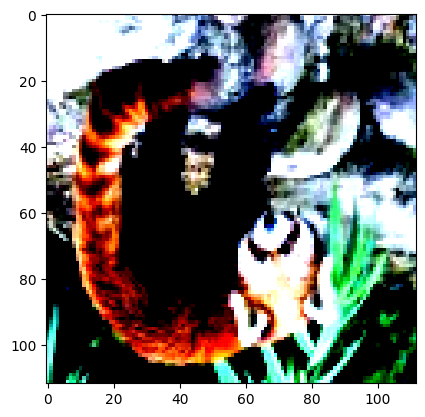

In [8]:
show_image(*dataset[200])

In [9]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [10]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)

(5330, 313, 627)

In [11]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


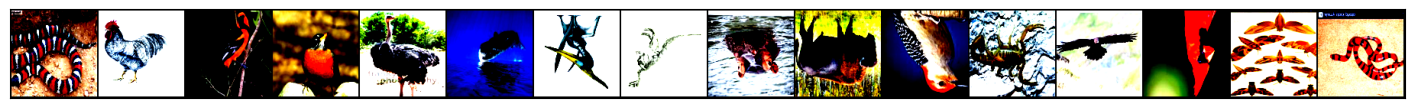

In [12]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [13]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 3*112*112
output_size = 151

In [17]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes

        # Use ResNet-50 instead of VGG16
        self.model = models.resnet50(pretrained=True)

        # Freeze the parameters of the pre-trained model
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, self.num_classes)

    def forward(self, X):
        X = self.model(X)
        return F.log_softmax(X, dim=1)

In [18]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Nathaniel/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 12.3MB/s]


ConvolutionalNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [19]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-4.8035, -5.4346, -4.9056, -5.2217, -4.8687, -5.0862, -5.2110, -4.7170,
        -5.1203, -4.1530, -4.9783, -4.8200, -5.3803, -5.0957, -5.0043, -4.7594,
        -4.7490, -4.5283, -5.1798, -5.4866, -5.3665, -5.2403, -5.1532, -4.9642,
        -5.3161, -4.8780, -4.8628, -5.3597, -4.9670, -4.6837, -5.4355, -4.3187,
        -4.8319, -4.6025, -4.7260, -5.4119, -5.1961, -4.4779, -5.4957, -4.8368,
        -4.8110, -5.2743, -5.1362, -4.3503, -6.3225, -6.0512, -5.2784, -4.4603,
        -5.2558, -5.1267, -5.1013, -4.9857, -5.8806, -5.0303, -4.9887, -4.6971,
        -4.9067, -5.3940, -5.6316, -5.1791, -5.0291, -4.7752, -5.4904, -5.0896,
        -4.9409, -5.4047, -4.8629, -5.3676, -4.6756, -4.6326, -5.1445, -4.3950,
        -5.1615, -5.3045, -5.6603, -5.4345, -4.7248, -4.4626, -5.4798, -5.0188,
        -4.5190, -4.9779, -5.3858, -5.3624, -4.7533, -5.5111, -4.7871, -5.6075,
        -5.2479, -5.0409, -4.8156, 

In [20]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [21]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
model = to_device(model, device)

In [23]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.157966613769531, 'val_acc': 0.02812500111758709}]

In [24]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 20
opt_func = torch.optim.RAdam
lr = 1e-4

627


In [25]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.9248, val_loss: 4.6912, val_acc: 0.1781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4483, val_loss: 4.1113, val_acc: 0.4410


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9039, val_loss: 3.5254, val_acc: 0.6045


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.3648, val_loss: 3.1376, val_acc: 0.6670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9085, val_loss: 2.7114, val_acc: 0.7281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.5424, val_loss: 2.4042, val_acc: 0.7569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.2765, val_loss: 2.2119, val_acc: 0.7670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.0725, val_loss: 2.1190, val_acc: 0.7608


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.9021, val_loss: 1.9431, val_acc: 0.7976


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.7576, val_loss: 1.7518, val_acc: 0.7819


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.6205, val_loss: 1.6727, val_acc: 0.8031


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.5389, val_loss: 1.7498, val_acc: 0.7726


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.4735, val_loss: 1.6254, val_acc: 0.7913


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.4014, val_loss: 1.6008, val_acc: 0.7913


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.3214, val_loss: 1.5484, val_acc: 0.7976


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.2885, val_loss: 1.6005, val_acc: 0.7920


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.2336, val_loss: 1.5111, val_acc: 0.8264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.2116, val_loss: 1.4810, val_acc: 0.8000


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.1422, val_loss: 1.4941, val_acc: 0.7826


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.1215, val_loss: 1.4455, val_acc: 0.8069


In [26]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

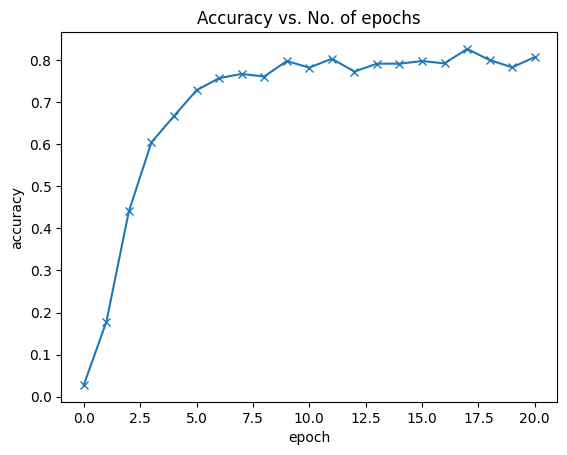

In [27]:
plot_accuracies(history)

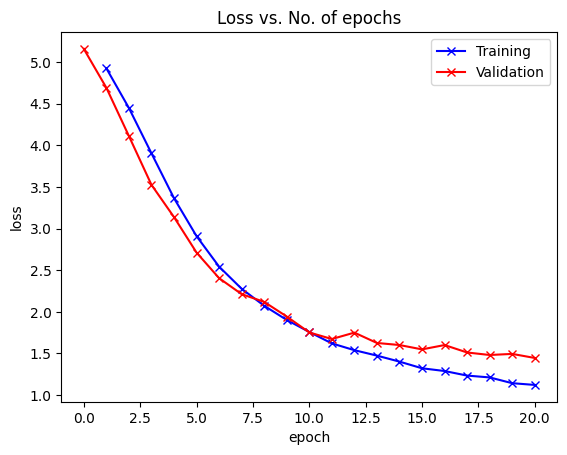

In [28]:
plot_losses(history)

In [29]:
evaluate(model, test_loader)

{'val_loss': 1.4172265529632568, 'val_acc': 0.8197917342185974}

## FLOPs

In [30]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 2.15G
